# Task 1 - Exploration of customer purchasing behavior

In [2]:
# importing libraries
import warnings
warnings.filterwarnings("ignore")
#Data Manipulation and Treatment
import numpy as np
import pandas as pd
from datetime import datetime
#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats
import itertools
#dvc
import dvc.api
import mlflow


In [3]:
#utils 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from plotsClass import Plot
from logger import App_Logger


In [3]:
logger = App_Logger("data_exploration.log").get_app_logger()

plot = Plot()

In [4]:
pd.set_option('max_column', None)
pd.set_option('display.float_format',lambda x:'%5f'%x)

# Data overview and cleaning data

In [5]:
# changing string to date
def str_to_date(date):
      """ changes string to data"""
      return datetime.strptime(date, '%Y-%m-%d').date()

<h3> Load the datasets <h3>

In [4]:
def read_csv(csv_path, missing_values=[]):
        try:
            df = pd.read_csv(csv_path, na_values=missing_values)
            print("file read as csv")
            logger.info(f"file read as csv from {csv_path}")
            return df
        except FileNotFoundError:
            print("file not found")
            logger.error(f"file not found, path:{csv_path}")

In [6]:
# reading a dataframe
df_train = pd.read_csv("../data/train.csv",sep=',', parse_dates=['Date'],date_parser=str_to_date, low_memory = False)

In [5]:
# reading the store data
df_store = read_csv("../data/store.csv")

file read as csv


In [8]:
# reading the test data
df_test = pd.read_csv("../data/test.csv",sep=',', parse_dates=['Date'], date_parser=str_to_date,
low_memory = False)

<h3>A quick view at the data on hand<h3>

In [9]:
df_train.head() 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [10]:
df_train.dtypes,print (f'The Train dataset has {str(df_train.shape[0])} Rows and {str(df_train.shape[1])} Variables')

The Train dataset has 1017209 Rows and 9 Variables


(Store                     int64
 DayOfWeek                 int64
 Date             datetime64[ns]
 Sales                     int64
 Customers                 int64
 Open                      int64
 Promo                     int64
 StateHoliday             object
 SchoolHoliday             int64
 dtype: object,
 None)

<h3>Calculating how many missing fields each variable has<h3>

In [11]:
df_train.count(0)/df_train.shape[0] * 100

Store           100.000000
DayOfWeek       100.000000
Date            100.000000
Sales           100.000000
Customers       100.000000
Open            100.000000
Promo           100.000000
StateHoliday    100.000000
SchoolHoliday   100.000000
dtype: float64

### no missing value found on train data set but a closer look at the Train set is needed

In [12]:
class cleaningTrainData :

    def __init__(self, df):
        
        self.df = df
    # changing string to date
    def drop (self,df,col1,col2):
      df=df.drop(df[(df[col1]== 0) & (df[col2]== 0)].index)
      df= df.reset_index(drop=True)
      return df
    def dropone (self,df,col1,col2):
      df=df.drop(df[(df[col1] == 1) & (df[col2] == 0)].index)
      df= df.reset_index(drop=True) 
      return df


### let us see Stores Closed (which means 0 customers and 0 sales) on Certain days:

In [13]:
print (f"-Over those two years, {df_train[(df_train.Open == 0)].count()[0]} is the number of times that different stores closed on given days.")
print ()
print (f"-From those closed events, {df_train[(df_train.Open == 0) & (df_train.SchoolHoliday == 1)&(df_train.StateHoliday == '0') ].count()[0]} times occured because there was a school holiday. ")
print ()
print ("-And {} times it occured because of either a bank holiday or easter or christmas.".format(df_train[(df_train.Open == 0) &
         ((df_train.StateHoliday == 'a') |
          (df_train.StateHoliday == 'b') | 
          (df_train.StateHoliday == 'c'))].count()[0]))
print ()
print ("-But interestingly enough, {} times those shops closed on days for no apparent reason when no holiday was announced. In fact, those closings were done with no pattern whatsoever and in this case from 2013 to 2015 at almost any month and any day.".format(df_train[(df_train.Open == 0) &
         (df_train.StateHoliday == "0")
         &(df_train.SchoolHoliday == 0)].count()[0]))
print ()

-Over those two years, 172817 is the number of times that different stores closed on given days.

-From those closed events, 3067 times occured because there was a school holiday. 

-And 30140 times it occured because of either a bank holiday or easter or christmas.

-But interestingly enough, 139610 times those shops closed on days for no apparent reason when no holiday was announced. In fact, those closings were done with no pattern whatsoever and in this case from 2013 to 2015 at almost any month and any day.



### since we don't want to bias our models to consider those exceptions, the best solution here is to get rid of closed stores and prevent the models to train on them and get false guidance.

### In this case we will analyse only open stores since a close store yield a profit of 0.

In [14]:
cleandata = cleaningTrainData(df_train)
df_train=cleandata.drop(df_train,col1= 'Open',col2='Sales')

In [15]:
print ("Our new training set has now {} rows ".format(df_train.shape[0]))

Our new training set has now 844392 rows 


## checking any outliers in the distribution of Sales and Customers in the train set

## 1)sales

In [16]:
df_train.Sales.describe()

count   844392.000000
mean      6955.514291
std       3104.214680
min          0.000000
25%       4859.000000
50%       6369.000000
75%       8360.000000
max      41551.000000
Name: Sales, dtype: float64

In [17]:
df_train.Sales.describe()

count   844392.000000
mean      6955.514291
std       3104.214680
min          0.000000
25%       4859.000000
50%       6369.000000
75%       8360.000000
max      41551.000000
Name: Sales, dtype: float64

### we see here a minimum of 0 which means some stores even opened got 0 sales on some days. since that can't happen we will drop it

In [18]:
df_train=cleandata.dropone(df_train,col1= 'Open',col2='Sales')

### An important metric to always check when looking at a distribution is how the mean compares to the median and how close are they from each other. As we see here a mean of 6955 versus 6369 in median is a very good sign that there are no extravagant values affecting the general distribution of Sales.

## 2) customer

In [19]:
df_train.Customers.describe()    

count   844338.000000
mean       762.777166
std        401.194153
min          8.000000
25%        519.000000
50%        676.000000
75%        893.000000
max       7388.000000
Name: Customers, dtype: float64

## Here there is huge difference between mean and median. This is due to a huge amount of customers in a store,When there is a big promotion going on. 

In [20]:
df_store.head() 

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000000,9.000000,2008.000000,0,NaN,NaN,NaN
1,2,a,a,570.000000,11.000000,2007.000000,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.000000,12.000000,2006.000000,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct"
3,4,c,c,620.000000,9.000000,2009.000000,0,NaN,NaN,NaN
4,5,a,a,29910.000000,4.000000,2015.000000,0,NaN,NaN,NaN


In [21]:
df_store.dtypes,print (f'The Store dataset has {str(df_store.shape[0])} Rows and {str(df_store.shape[1])} Variables')

The Store dataset has 1115 Rows and 10 Variables


(Store                          int64
 StoreType                     object
 Assortment                    object
 CompetitionDistance          float64
 CompetitionOpenSinceMonth    float64
 CompetitionOpenSinceYear     float64
 Promo2                         int64
 Promo2SinceWeek              float64
 Promo2SinceYear              float64
 PromoInterval                 object
 dtype: object,
 None)

### let us look further in to store data

In [22]:
# calculating fill rate
df_store.count(0)/df_store.shape[0] * 100

Store                       100.000000
StoreType                   100.000000
Assortment                  100.000000
CompetitionDistance          99.730942
CompetitionOpenSinceMonth    68.251121
CompetitionOpenSinceYear     68.251121
Promo2                      100.000000
Promo2SinceWeek              51.210762
Promo2SinceYear              51.210762
PromoInterval                51.210762
dtype: float64

### CompetitionOpenSinceMonth and CompetitionOpenSinceYear, it's  missing data that we're dealing with here (68.25% fill rate), this means that we have the nearest distance of the competitor but miss the date information on when did he actually opened next to the Rossman store.

### But The Promo2SinceWeek,Promo2SinceYear and PromoInterval variables has 51% fill rate since they are actually NULL values because there are no continuous promotion for those stores.


## Dealing with the missing value

### computing missing value for Competition Distance

In [23]:
df_store[pd.isnull(df_store.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.000000,2013.000000,"Feb,May,Aug,Nov"


### only 3 rows with null values for Competition Distance Before deciding how to treat this, Let's quickly have a look at those metrics.

In [24]:
{"Mean":np.nanmean(df_store.CompetitionDistance),"Median":np.nanmedian(df_store.CompetitionDistance),"Standard Dev":np.nanstd(df_store.CompetitionDistance)}

{'Mean': 5404.901079136691,
 'Median': 2325.0,
 'Standard Dev': 7659.7282732764415}

We see a highly right skewed distribution for this variable with a significant difference between the mean and the median. This being caused by the amount of disperness in the data with a standard deviation of 7659, higher than the mean and the median.

SO it is realistically better to input the median value to the three Nan stores then the mean since the mean is biased by those outliers.

In [25]:
df_store = plot.fill_median(df_store,col1='CompetitionDistance')

### computing missing value for CompetitionOpenSinceMonth and CompetitionOpenSinceYear

Since we have no information whatsoever on those missing values and no accurate way of filling those values. I assigned zero to the missing value

In [26]:
df_store.CompetitionOpenSinceMonth.fillna(0, inplace = True)
df_store.CompetitionOpenSinceYear.fillna(0,inplace=True)

### computing missing value for Promo2SinceWeek, Promo2SinceYear and PromoInterval

In [27]:
df_store[pd.isnull(df_store.Promo2SinceWeek)]


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000000,9.000000,2008.000000,0,NaN,NaN,NaN
3,4,c,c,620.000000,9.000000,2009.000000,0,NaN,NaN,NaN
4,5,a,a,29910.000000,4.000000,2015.000000,0,NaN,NaN,NaN
5,6,a,a,310.000000,12.000000,2013.000000,0,NaN,NaN,NaN
6,7,a,c,24000.000000,4.000000,2013.000000,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.000000,4.000000,2004.000000,0,NaN,NaN,NaN
1109,1110,c,c,900.000000,9.000000,2010.000000,0,NaN,NaN,NaN
1111,1112,c,c,1880.000000,4.000000,2006.000000,0,NaN,NaN,NaN
1112,1113,a,c,9260.000000,0.000000,0.000000,0,NaN,NaN,NaN


In [28]:
df_store[pd.isnull(df_store.Promo2SinceWeek)& (df_store.Promo2==0)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.000000,9.000000,2008.000000,0,NaN,NaN,NaN
3,4,c,c,620.000000,9.000000,2009.000000,0,NaN,NaN,NaN
4,5,a,a,29910.000000,4.000000,2015.000000,0,NaN,NaN,NaN
5,6,a,a,310.000000,12.000000,2013.000000,0,NaN,NaN,NaN
6,7,a,c,24000.000000,4.000000,2013.000000,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.000000,4.000000,2004.000000,0,NaN,NaN,NaN
1109,1110,c,c,900.000000,9.000000,2010.000000,0,NaN,NaN,NaN
1111,1112,c,c,1880.000000,4.000000,2006.000000,0,NaN,NaN,NaN
1112,1113,a,c,9260.000000,0.000000,0.000000,0,NaN,NaN,NaN


This means all the missing values comes from fields where Promo2=0 which means there are no continuous promotional activities for those stores. Having no promotion means those fields have to be 0 as well since they are linked to Promo2. so we will place zero in the missing value place


In [29]:
# filling missing value for the three column
df_store.Promo2SinceWeek.fillna(0,inplace=True)
df_store.Promo2SinceYear.fillna(0,inplace=True)
df_store.PromoInterval.fillna(0,inplace=True)

In [30]:
# checking for missing values on the store data
df_store.count(0)/df_store.shape[0] * 100

Store                       100.000000
StoreType                   100.000000
Assortment                  100.000000
CompetitionDistance         100.000000
CompetitionOpenSinceMonth   100.000000
CompetitionOpenSinceYear    100.000000
Promo2                      100.000000
Promo2SinceWeek             100.000000
Promo2SinceYear             100.000000
PromoInterval               100.000000
dtype: float64

## Merging train and store data set using left join

In [31]:
df_train_store = pd.merge(df_train, df_store, how = 'left', on = 'Store')
df_train_store.head() 

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.000000,9.000000,2008.000000,0,0.000000,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.000000,11.000000,2007.000000,1,13.000000,2010.000000,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.000000,12.000000,2006.000000,1,14.000000,2011.000000,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.000000,9.000000,2009.000000,0,0.000000,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.000000,4.000000,2015.000000,0,0.000000,0.000000,0


In [32]:
print ("The Train_Store dataset has {} Rows and {} Variables".format(str(df_train_store.shape[0]),str(df_train_store.shape[1])))

The Train_Store dataset has 844338 Rows and 18 Variables


In [33]:
df_train_store.to_csv('../data/train_store.csv', index= False)

## Plotting  distribution of promotion in both Data sets 

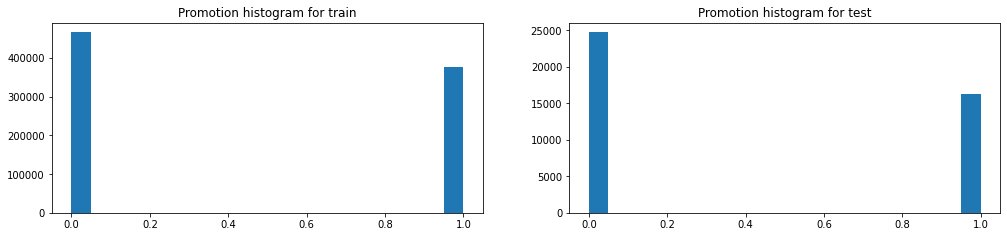

In [34]:
plot.plot_sub(df_train,df_test,col='Promo',title1='train',title2='test')

##  Check & compare sales behavior before, during and after holidays

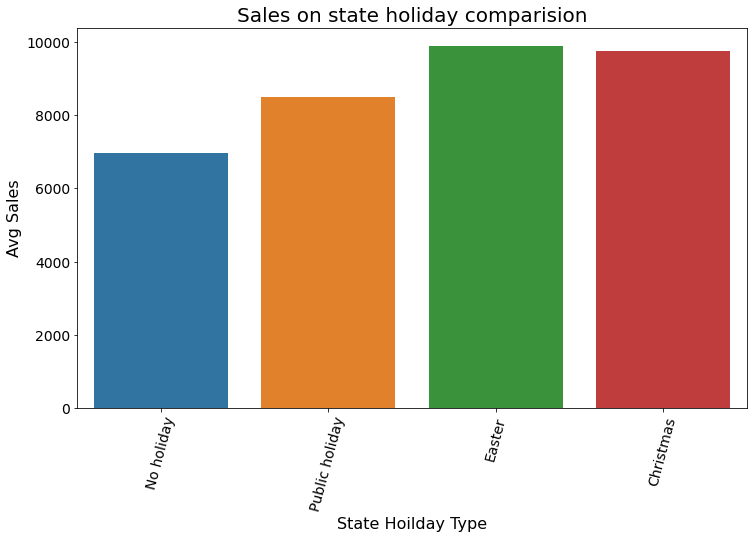

In [35]:
# Sales Comparision on State Holiday

train_store_holiday = df_train_store.groupby('StateHoliday').agg({'Sales': 'mean'})
train_store_holiday = train_store_holiday.rename(index={'0': 'No holiday', 'a': 'Public holiday','b': 'Easter', 'c': 'Christmas'})
plot.plot_bar(train_store_holiday, train_store_holiday.index, 'Sales', 'Sales on state holiday comparision','State Hoilday Type', 'Avg Sales')

As we can see the average sales for holidays is greater than non holidays and the average sales of easter is greater than all of them 

##  Find out any seasonal (Christmas, Easter etc) purchase behaviours

### Purchase behavior on Christmas during 2013/2014

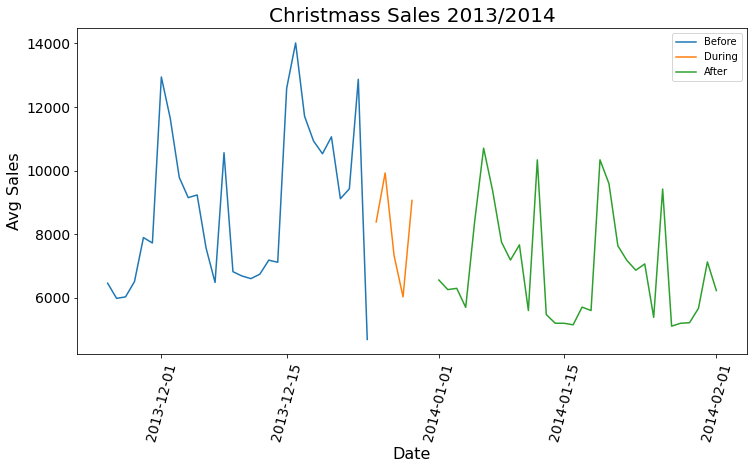

In [36]:
before_index = (df_train_store["Date"] >= pd.to_datetime("2013-11-25")) & (df_train_store["Date"] < pd.to_datetime("2013-12-25"))
before_xmass = df_train_store[before_index].groupby("Date").agg({"Sales": "mean"})

during_index = (df_train_store["Date"] >= pd.to_datetime("2013-12-25")) & (df_train_store["Date"] < pd.to_datetime("2013-12-30"))
during_xmass = df_train_store[during_index].groupby("Date").agg({"Sales": "mean"})

after_index = (df_train_store["Date"] >= pd.to_datetime("2014-01-01")) & (df_train_store["Date"] < pd.to_datetime("2014-02-02"))
after_xmass = df_train_store[after_index].groupby("Date").agg({"Sales": "mean"})


plt.figure(figsize=(12, 6))

sns.lineplot(x = before_xmass.index, y = before_xmass["Sales"], label='Before')
sns.lineplot(x = during_xmass.index, y = during_xmass["Sales"], label='During')
sns.lineplot(x = after_xmass.index, y = after_xmass["Sales"], label='After')

plt.title("Christmass Sales 2013/2014", size=20)
plt.xticks(rotation=75, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(xlabel="Date", fontsize=16)
plt.ylabel(ylabel="Avg Sales", fontsize=16)
plt.show()

### As we can see avg sales before christmas is higher than the rest. Avg sales during christmas is lower from the three.

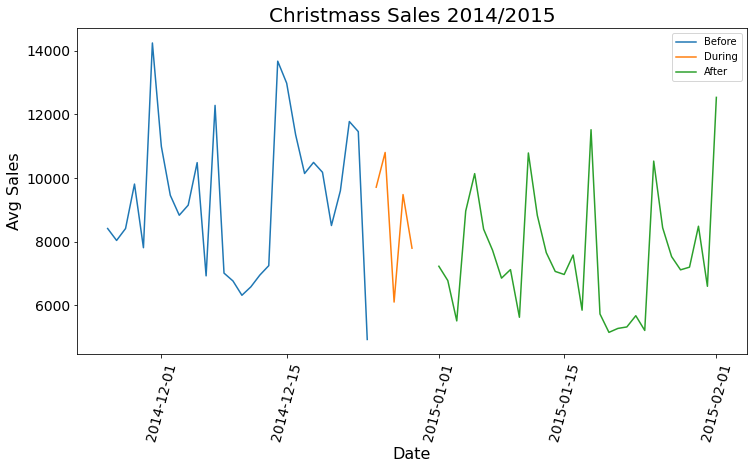

In [37]:
before_index = (df_train_store["Date"] >= pd.to_datetime("2014-11-25")) & (df_train_store["Date"] < pd.to_datetime("2014-12-25"))
before_xmass = df_train_store[before_index].groupby("Date").agg({"Sales": "mean"})

during_index = (df_train_store["Date"] >= pd.to_datetime("2014-12-25")) & (df_train_store["Date"] < pd.to_datetime("2014-12-30"))
during_xmass = df_train_store[during_index].groupby("Date").agg({"Sales": "mean"})

after_index = (df_train_store["Date"] >= pd.to_datetime("2015-01-01")) & (df_train_store["Date"] < pd.to_datetime("2015-02-02"))
after_xmass = df_train_store[after_index].groupby("Date").agg({"Sales": "mean"})


plt.figure(figsize=(12, 6))

sns.lineplot(x = before_xmass.index, y = before_xmass["Sales"], label='Before')
sns.lineplot(x = during_xmass.index, y = during_xmass["Sales"], label='During')
sns.lineplot(x = after_xmass.index, y = after_xmass["Sales"], label='After')

plt.title("Christmass Sales 2014/2015", size=20)
plt.xticks(rotation=75, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(xlabel="Date", fontsize=16)
plt.ylabel(ylabel="Avg Sales", fontsize=16)
plt.show()

### Here also it has the same trend as last year.

##  What can you say about the correlation between sales and number of customers?

In [38]:
stats.pearsonr(df_train.Customers, df_train.Sales)[0]

0.823551720200022

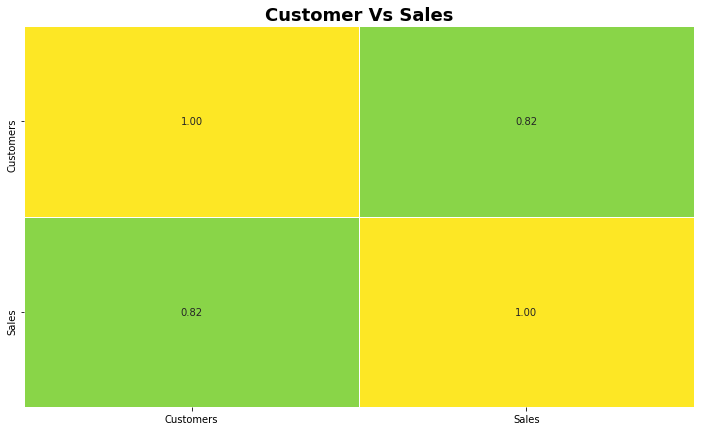

In [39]:
cor=df_train[['Customers','Sales']].corr()
plot.plot_heatmap(cor, 'Customer Vs Sales')

### We can see similair patterns with the customers column and the Sales column, in fact our pearson correlation factor of 0.82 explains that there is a strong positive correlation between Sales and Customers.

## 5) Promotion

Let's see how Promotion affect the overall sales of Rossman by looking at when there is and when there isn't promotion over those 3 years. This allow us first to see the impact of promotion and as well to see the evolution of sales over specific years (so trends in a given year) and the gradual increase in sales from 2013 to 2015.

In [40]:
# creating month and year columns  
df_train_store['Month']=df_train_store.Date.dt.month
df_train_store['Year']=df_train_store.Date.dt.year

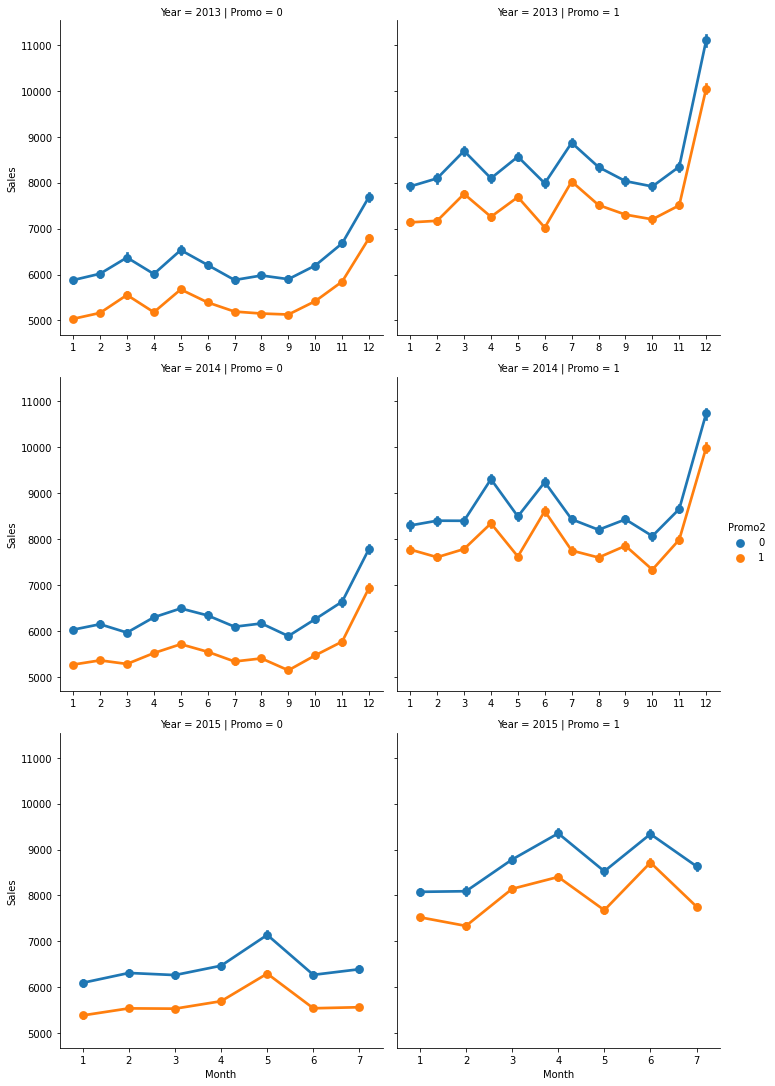

In [41]:
sns.factorplot(data = df_train_store, x ="Month", y = 'Sales',col = 'Promo',  hue = 'Promo2', row = 'Year' ,sharex=False)

We can see that there is a great change when we compare having promotion Promo=1 to not having promotion Promo=0 and can conclude that a store that have promotion on a given day changes its amount of sales considerably.

## Now let us check if the promos attracting more customers

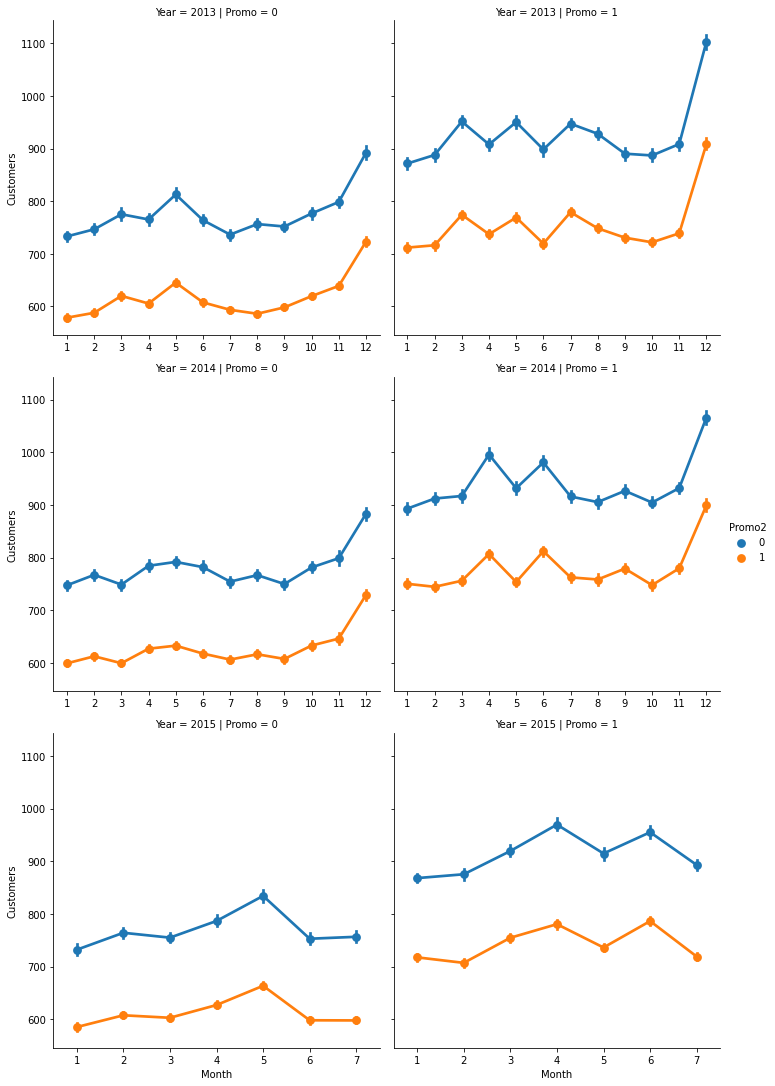

In [42]:
sns.factorplot(data = df_train_store, x ="Month", y = 'Customers',col = 'Promo',  hue = 'Promo2', row = 'Year' ,sharex=False)

## Here we can see that there is a change in the number of customers when we compare having promotion Promo=1 to not having promotion Promo=0 and also a growth from to year to year. Eventhough there is a change the change is not as much as sales. so we can conclude that the promos are attracting new customers but the increasing rate of customers and increasing rate of sales is not equivalent.

## To see how it affect already existing customers let us create new columns called sales per customer.

In [43]:
df_train_store['SalesperCustomer']=df_train_store['Sales']/df_train_store['Customers']
df_train_store.head()
df_train_store.to_csv('../data/train_store.csv', index=False)

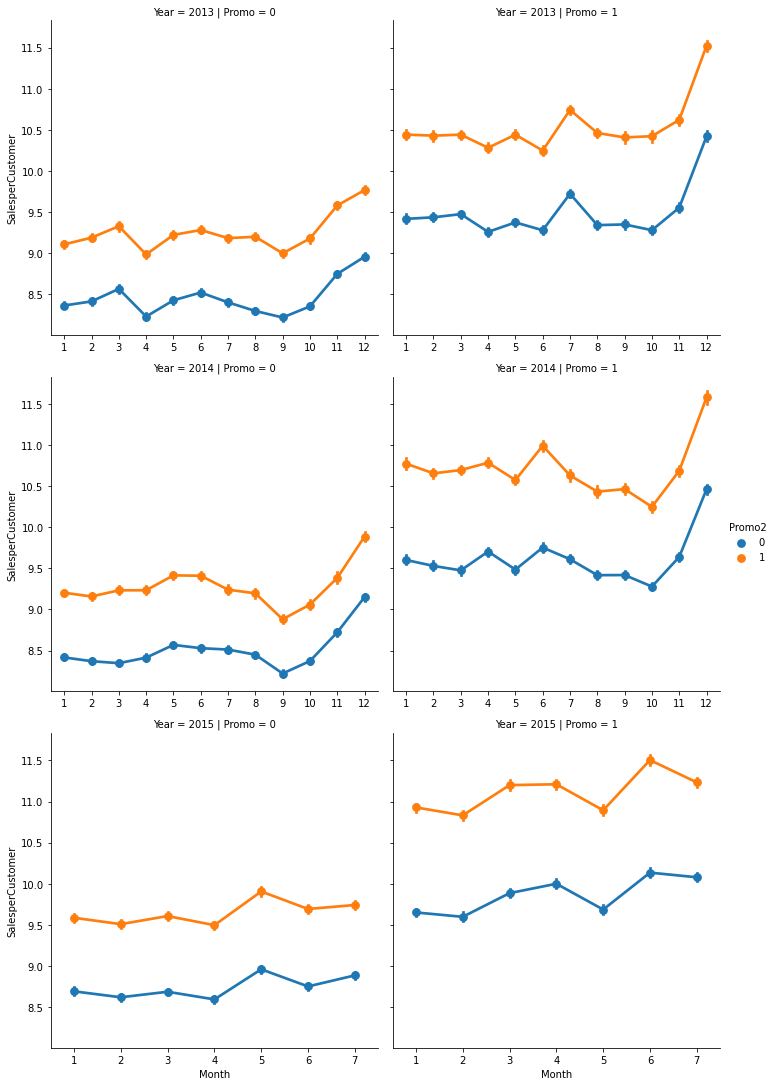

In [44]:
sns.factorplot(data = df_train_store, x ='Month', y = 'SalesperCustomer', col = 'Promo', hue = 'Promo2',row = 'Year',sharex=False)

### As we can see from the graph the sales per customer has increased when there is promotion.From the graphs we can conclude that the existing customer are buying more due to the promotion.  

## 6.1)For the question Could the promos be deployed in more effective ways? 

### From the above graph  the Promo2 variable (indicating a continuous promotion blue vs orange) we see that in general when there is no consecutive promotion stores tend to sell more than with consecutive promotion. so the best way to deploy the Promos is with out consecutive promotion.

## 6.2For the question Which stores should promos be deployed in?

### The best way to asses the performance of a store type is to see what is the sales per customer so that we normalize everything and we get the store that makes its customers spend the most on average.

### Let's compare first the total sales of each store type, its average sales and then see how it changes when we add the customers to the equation:

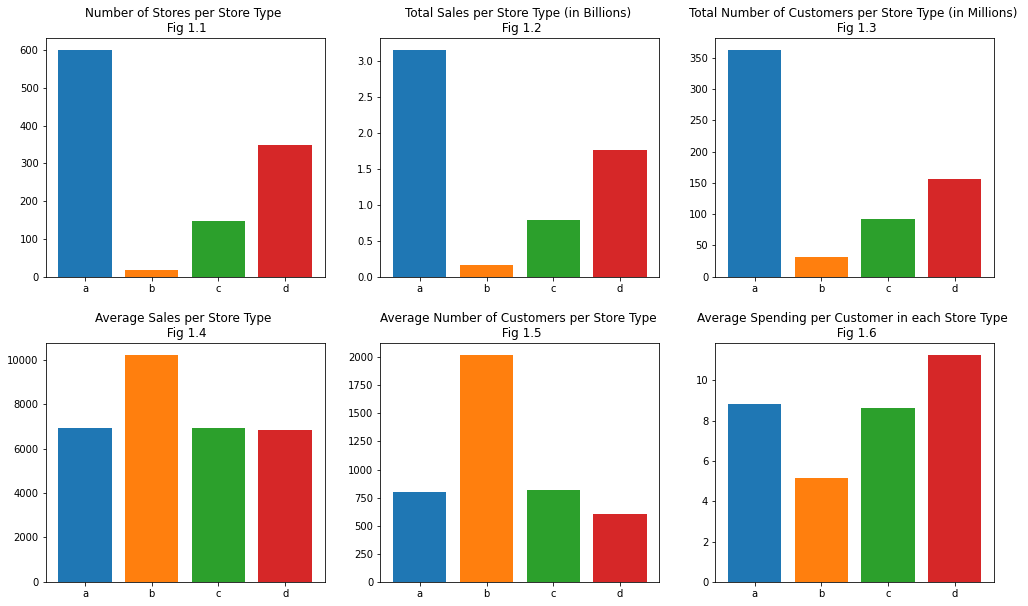

In [45]:
fig, axes = plt.subplots(2, 3,figsize=(17,10) )
palette = itertools.cycle(sns.color_palette(n_colors=4))
plt.subplots_adjust(hspace = 0.28)
axes[0,0].bar(df_store.groupby(by="StoreType").count().Store.index,df_store.groupby(by="StoreType").count().Store,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,0].set_title("Number of Stores per Store Type \n Fig 1.1")
axes[0,1].bar(df_train_store.groupby(by="StoreType").sum().Sales.index,df_train_store.groupby(by="StoreType").sum().Sales/1e9,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,1].set_title("Total Sales per Store Type (in Billions) \n Fig 1.2")
axes[0,2].bar(df_train_store.groupby(by="StoreType").sum().Customers.index,df_train_store.groupby(by="StoreType").sum().Customers/1e6,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,2].set_title("Total Number of Customers per Store Type (in Millions) \n Fig 1.3")
axes[1,0].bar(df_train_store.groupby(by="StoreType").sum().Customers.index,df_train_store.groupby(by="StoreType").Sales.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,0].set_title("Average Sales per Store Type \n Fig 1.4")
axes[1,1].bar(df_train_store.groupby(by="StoreType").sum().Customers.index,df_train_store.groupby(by="StoreType").Customers.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,1].set_title("Average Number of Customers per Store Type \n Fig 1.5")
axes[1,2].bar(df_train_store.groupby(by="StoreType").sum().Sales.index,df_train_store.groupby(by="StoreType").SalesperCustomer.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,2].set_title("Average Spending per Customer in each Store Type \n Fig 1.6")
plt.show()

# Findings

### From this training set we can see that Storetype A has the highest number of branches,sales and customers from the 4 different storetypes. But this doesn't mean it's the best performing Storetype.

### When looking at the average sales and number of customers, we see that actually it is Storetype B who was the highest average Sales and highest average Number of Customers. so store type a,c and d  needs more promotion to increase the average sales and number of customers 

## Trends of customer behavior during store open and closing times


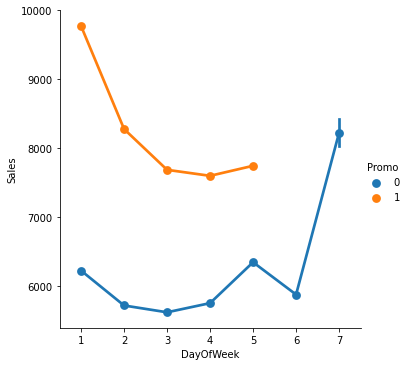

In [46]:
sns.factorplot(data = df_train_store, x ="DayOfWeek", y = "Sales", hue='Promo' ,sharex=False) 

### We see a big difference again even on a week level (from Monday to Friday) when we seperate promotion and no promotion.We see there are no promotions during the weekend
### All the time there is a peak on Mondays(During opening times) with promotions, a tiny peak on Friday before the weekend and a big peak on Sunday because of closed stores.

##  Check how the assortment type affects sales

StoreType  Assortment
a          a             381
           c             221
b          a               7
           b               9
           c               1
c          a              77
           c              71
d          a             128
           c             220
Name: Assortment, dtype: int64

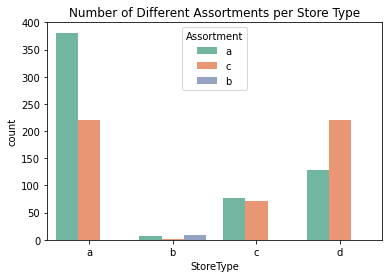

In [47]:
StoretypeXAssortment = sns.countplot(x="StoreType",hue="Assortment",order=["a","b","c","d"], data=df_store,palette=sns.color_palette("Set2", n_colors=3)).set_title("Number of Different Assortments per Store Type")
df_store.groupby(by=["StoreType","Assortment"]).Assortment.count()

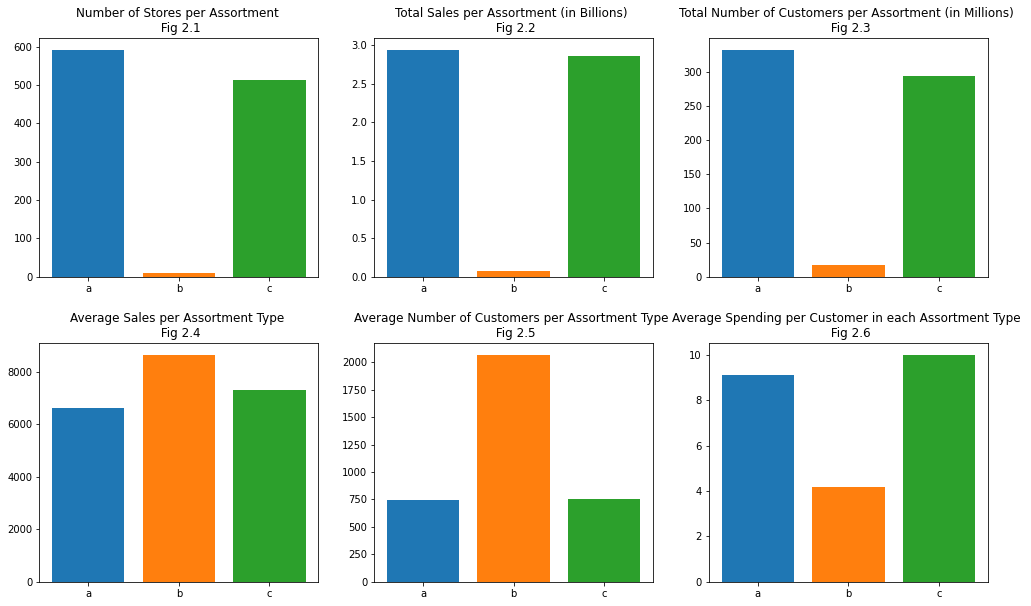

In [48]:
fig, axes = plt.subplots(2, 3,figsize=(17,10) )
palette = itertools.cycle(sns.color_palette(n_colors=4))
plt.subplots_adjust(hspace = 0.28)
#axes[1].df_train_store.groupby(by="StoreType").count().Store.plot(kind='bar')
axes[0,0].bar(df_store.groupby(by="Assortment").count().Store.index,df_store.groupby(by="Assortment").count().Store,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,0].set_title("Number of Stores per Assortment \n Fig 2.1")
axes[0,1].bar(df_train_store.groupby(by="Assortment").sum().Sales.index,df_train_store.groupby(by="Assortment").sum().Sales/1e9,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,1].set_title("Total Sales per Assortment (in Billions) \n Fig 2.2")
axes[0,2].bar(df_train_store.groupby(by="Assortment").sum().Customers.index,df_train_store.groupby(by="Assortment").sum().Customers/1e6,color=[next(palette),next(palette),next(palette),next(palette)])
axes[0,2].set_title("Total Number of Customers per Assortment (in Millions) \n Fig 2.3")
axes[1,0].bar(df_train_store.groupby(by="Assortment").sum().Customers.index,df_train_store.groupby(by="Assortment").Sales.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,0].set_title("Average Sales per Assortment Type \n Fig 2.4")
axes[1,1].bar(df_train_store.groupby(by="Assortment").sum().Customers.index,df_train_store.groupby(by="Assortment").Customers.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,1].set_title("Average Number of Customers per Assortment Type \n Fig 2.5")
axes[1,2].bar(df_train_store.groupby(by="Assortment").sum().Sales.index,df_train_store.groupby(by="Assortment").SalesperCustomer.mean(),color=[next(palette),next(palette),next(palette),next(palette)])
axes[1,2].set_title("Average Spending per Customer in each Assortment Type \n Fig 2.6")
plt.show()

## Findings
    
### We can clearly see here that most of the stores have either a assortment type or c assortment type.
### Interestingly enough StoreType d which has the highest Sales per customer average actually has mostly c assortment type, this is most probably the reason for having this high average in Sales per customer.Having variery in stores always increases the customers spending pattern.
### Another important factor here is the fact that store type b is the only one who has the b assortment type and a lot of them actually which stands for "extra" and by looking at fig 1.4 and 1.5 he's the one who has the highest number of customers and sales. Probably this formula of extra is the right middlepoint for customers between not too much variety like C assortment and not too basic like A assortment and this is what is driving the high traffic in this store